# Chalearn Data Analysis

In [20]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from extract_feat_stage4 import createXY_train, createXY_valid, createXY_test, peform_PCA
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## 1) Import Data
* Features extracted using a 3D RexNeXt-101 model, pretrained on the Kitenics dataset
* Features are provided as a 2048 dimensional vectors for each 16 frame segment of a video. These were concatenated and the mean value was kept, producing a single 2048 dimensional vector for one entire video
* Classification is performed for the 'extraversion' label since it has the most datasamples after binarizing at values > 0.5 with 55% of the data samples being positive examples (the rest of the labels has at best 43% positive examples) accross the entire dataset of 6000 videos. 

In [3]:
print('loading training data')
X_train, Y_train = createXY_train()
print('X_train-dim = ', X_train.ndim, '  Y_train-dim = ', Y_train.ndim)

loading training data
X_train-dim =  2   Y_train-dim =  1


NameError: name 'X' is not defined

In [6]:
np.save('X_train.npy', X_train) 
np.save('Y_train.npy', Y_train) 

In [7]:
print('loading validation data')
X_valid, Y_valid = createXY_valid()
print('X_valid-dim = ', X_valid.ndim, '  Y_valid-dim = ', Y_valid.ndim)
print(len(X_valid))
print(len(Y_valid))

loading validation data
X_valid-dim =  2   Y_valid-dim =  1
2000
2000


In [8]:
np.save('X_valid.npy', X_valid) 
np.save('Y_valid.npy', Y_valid) 

In [59]:
print('loading testing data')
X_test, Y_test = createXY_test()
print('X_test-dim = ', X_test.ndim, '  Y_test-dim = ', Y_test.ndim)
print(len(X_test))
print(len(Y_test))

loading testing data
X_test-dim =  2   Y_test-dim =  1
2000
2000


## 2) PCA

number of components =  80


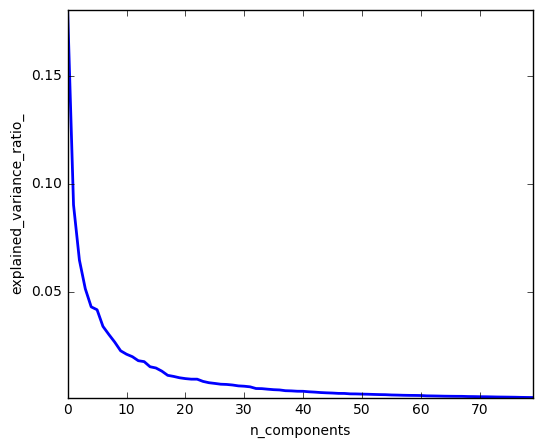

In [24]:
#from sklearn.decomposition import PCA
import importlib 
importlib.reload(extract_feat_stage4)
X_train_pca, X_valid_pca = peform_PCA(X_train, X_valid, 0.95) 
#X_train_pca, X_valid_pca, X_test_pca  = peform_PCA(X_train, X_valid, X_test, 0.95) 

## 3) Training

In [88]:
from sklearn.metrics import roc_auc_score, roc_curve

# Plot the ROC curve and return AUC
def plotROC(y_test, y_pred):    
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)  # AUC metric
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.plot([0, 1], [0, 1], 'k--')

    plt.show()

## Random Forest Classifier

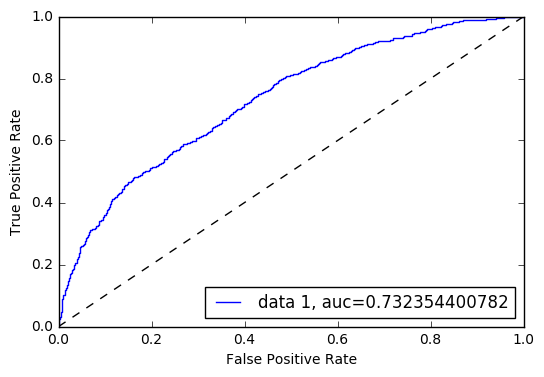

In [90]:
from sklearn.ensemble import RandomForestClassifier

regr2 = RandomForestClassifier(n_estimators=400, min_samples_leaf=50, n_jobs=-1)

regr2.fit(X_train_pca, Y_train)

y_pred_rf2 = regr2.predict_proba(X_valid_pca)[:,1] 
plotROC(Y_valid, y_pred_rf2)

## Multiple models

In [78]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,  GradientBoostingClassifier, RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


models_names = ['Logistic Regression',
                'Decision Tree',
                'Bernoulli Naive Bayes',
                'Gaussian Naive Bayes', 
                'Random Forest',
                'Ada Boost',
                'Gradient Boosting',
                'Neural Network',
               'KNeighborsClassifier(n_neighbors=3)',
               'SVM']

models = [LogisticRegression(),
          tree.DecisionTreeClassifier(min_samples_leaf=4),
          BernoulliNB(),
          GaussianNB(),
          RandomForestClassifier(n_estimators=400, min_samples_leaf=4, n_jobs=-1), 
          AdaBoostClassifier(), 
          GradientBoostingClassifier(),
          MLPClassifier(max_iter = 10000, alpha = 1e-3, hidden_layer_sizes=(100, 100)
),
          KNeighborsClassifier(n_neighbors=2),
          SVC(kernel='linear', class_weight={1: 10})]


features_names = ['All']

features = [(X_train_pca, X_valid_pca)]

In [79]:
# Benchmark classifiers
def benchmark(clf, train_X, test_X):
    Y_train_df = pd.DataFrame(Y_train)
    Y_valid_df = pd.DataFrame(Y_valid)

    
    clf.fit(train_X, Y_train_df.values.ravel())
    
    pred = clf.predict(test_X)
    
    score = cross_val_score(clf, test_X, Y_valid_df.values.ravel(), cv=5)
    
    cm = confusion_matrix(Y_valid_df.values.ravel(),pred)
    
    fpr, tpr, thresholds = roc_curve(Y_valid_df, pred)
    
    roc_auc = auc(fpr, tpr)
    return roc_auc, np.mean(score)

Training
completed


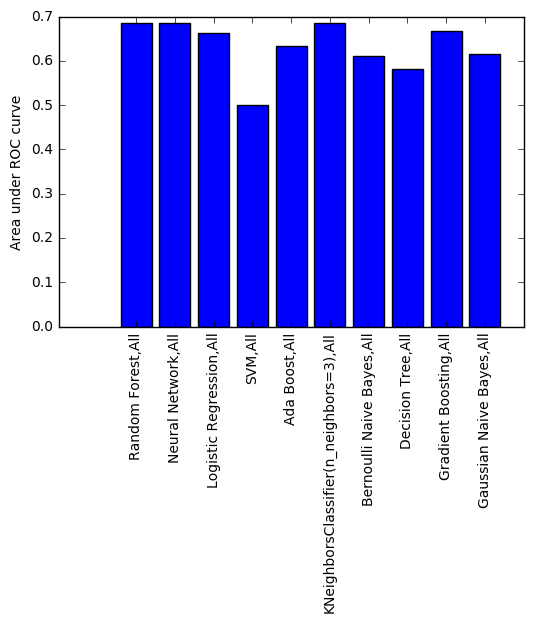

In [80]:
acc_train = {}
auc_train = {}
print('Training')
for clf, name in zip(models, models_names):
    for feat, feat_name in zip(features, features_names):
        final_n = name + ',' + feat_name
        auc_train[final_n], acc_train[final_n] = benchmark(clf, feat[0], feat[1])
print('completed')

auc_sort= sorted(auc_train.items(), key=lambda x: x[1], reverse = True)
auc_sort = dict(auc_sort[:15])
plt.bar(range(len(auc_sort)), auc_sort.values(), align='center')
plt.ylabel('Area under ROC curve')
plt.xticks(range(len(auc_sort)), list(auc_sort.keys()), rotation='vertical')
plt.show()

Iteration 1, loss = 0.63129107
Iteration 2, loss = 0.57722465
Iteration 3, loss = 0.54789664
Iteration 4, loss = 0.51925390
Iteration 5, loss = 0.48856005
Iteration 6, loss = 0.46833871
Iteration 7, loss = 0.43974337
Iteration 8, loss = 0.42027989
Iteration 9, loss = 0.39931932
Iteration 10, loss = 0.38545183
Iteration 11, loss = 0.36185717
Iteration 12, loss = 0.34511365
Iteration 13, loss = 0.32746841
Iteration 14, loss = 0.32466036
Iteration 15, loss = 0.30230990
Iteration 16, loss = 0.28073284
Iteration 17, loss = 0.28004438
Iteration 18, loss = 0.26387058
Iteration 19, loss = 0.25189170
Iteration 20, loss = 0.23743072
Iteration 21, loss = 0.23880831
Iteration 22, loss = 0.22336284
Iteration 23, loss = 0.20519303
Iteration 24, loss = 0.19901768
Iteration 25, loss = 0.18931172
Iteration 26, loss = 0.19784659
Iteration 27, loss = 0.19827799
Iteration 28, loss = 0.16986239
Iteration 29, loss = 0.17000731
Iteration 30, loss = 0.15547850
Iteration 31, loss = 0.16198472
Iteration 32, los

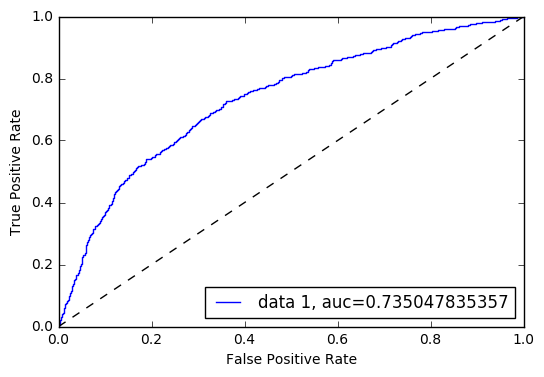

In [85]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=10000, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train_pca, Y_train)

pred = mlp.predict_proba(X_valid_pca)[:,1] 
plotROC(Y_valid, pred)
